#  Klasifikasi Teks untuk mendeteksi SMS Spam

## Import library
Mengimport Library yang diperlukan yang mendukung proses pengunduhan dataset, pengolahan data, pembangunan model, evaluasi model, hingga visualisasi hasil.

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard


## Mengunduh dan Mengekstrak Dataset
- Kode di bawah ini menentukan URL dataset SMS Spam Collection dari UCI Machine Learning Repository. File ZIP akan diunduh dan disimpan dengan nama smsspamcollection.zip.
- Dataset diunduh menggunakan requests, kemudian diekstrak menggunakan pustaka zipfile. Folder hasil ekstraksi diperiksa dengan os.listdir.

In [4]:
import requests
import zipfile
import os

# URL dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
zip_file_path = 'smsspamcollection.zip'
extracted_folder = 'smsspamcollection/'

# Mengunduh file ZIP
r = requests.get(url)
with open(zip_file_path, 'wb') as f:
    f.write(r.content)

# Mengekstrak file ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# Melihat isi folder hasil ekstraksi
os.listdir(extracted_folder)


['readme', 'SMSSpamCollection']

## Memuat Dataset, Memproses Label dan Membagi Dataset
- Dataset dimuat menggunakan pandas. File dipisahkan oleh tab (\t) dengan dua kolom: label (spam atau ham) dan message (teks SMS).
- Kolom label yang awalnya berupa teks (ham, spam) dikonversi menjadi angka menggunakan LabelEncoder. ham menjadi 0 dan spam menjadi 1.
- Dataset dipisahkan menjadi dua bagian: fitur (X, berupa pesan teks) dan label (y, berupa angka 0 atau 1). Kemudian, dataset dibagi menjadi data pelatihan (80%) dan data pengujian (20%).

In [ ]:
import pandas as pd

# Memuat dataset dari file yang diekstrak
file_path = os.path.join(extracted_folder, 'SMSSpamCollection')
data = pd.read_csv(file_path, sep='\t', header=None, names=['label', 'message'])

# Mengonversi label teks menjadi numerik (0 = ham, 1 = spam)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

# Pisahkan fitur dan label
X = data['message']
y = data['label']

# Bagi dataset menjadi data pelatihan dan pengujian
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Tokenisasi dan Padding
Pesan teks dikonversi menjadi urutan angka menggunakan Tokenizer dari Keras, di mana hanya 5000 kata yang paling sering muncul digunakan. Kemudian, urutan angka tersebut dipotong atau dilengkapi hingga panjang maksimal 100 token dengan pad_sequences.

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenisasi data teks
tokenizer = Tokenizer(num_words=5000)  # Hanya menggunakan 5000 kata yang paling sering muncul
tokenizer.fit_on_texts(X_train)  # Melatih tokenizer dengan data pelatihan

# Mengonversi teks menjadi urutan angka
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding untuk memastikan semua input memiliki panjang yang sama
X_train_pad = pad_sequences(X_train_seq, maxlen=100)  # Padding panjang 100 token
X_test_pad = pad_sequences(X_test_seq, maxlen=100)


## Membangun Model Neural Network dan Melatih Model
- Model jaringan neural dibuat menggunakan API Sequential Keras. Lapisan meliputi:
    1. Embedding: Mengonversi angka menjadi representasi vektor berdimensi 64.
    2. GlobalAveragePooling1D: Mengambil rata-rata dari representasi vektor untuk setiap input.
    3. Dense Layer: Lapisan penuh dengan 64 unit dan fungsi aktivasi ReLU.
    4. Output Layer: Lapisan sigmoid menghasilkan output probabilitas (0 untuk ham, 1 untuk spam).
- Model disusun menggunakan optimizer Adam, fungsi loss binary_crossentropy, dan metrik akurasi. TensorBoard digunakan untuk memantau pelatihan. Model dilatih selama 5 epoch dengan data pelatihan dan divalidasi menggunakan data pengujian.

In [7]:
from tensorflow.keras import layers, models

# Membangun model
model = models.Sequential([
    layers.Embedding(input_dim=5000, output_dim=64),  # Tidak perlu input_length
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output 0 atau 1
])

# Menyusun model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [8]:
# Setup untuk TensorBoard
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

# Melatih model
history = model.fit(X_train_pad, y_train, epochs=5, validation_data=(X_test_pad, y_test), callbacks=[tensorboard_callback])


Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8674 - loss: 0.4005 - val_accuracy: 0.8664 - val_loss: 0.3556
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8577 - loss: 0.3601 - val_accuracy: 0.8664 - val_loss: 0.2873
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8864 - loss: 0.2375 - val_accuracy: 0.9587 - val_loss: 0.1139
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9721 - loss: 0.0990 - val_accuracy: 0.9848 - val_loss: 0.0816
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9844 - loss: 0.0565 - val_accuracy: 0.9848 - val_loss: 0.0655


## Evaluasi dan Penyimpanan Model
Model diuji pada data pengujian untuk mengukur akurasi dan disimpan dalam file .h5.

In [9]:
# Evaluasi model
test_loss, test_acc = model.evaluate(X_test_pad, y_test)
print(f'Test accuracy: {test_acc}')


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9866 - loss: 0.0704
Test accuracy: 0.9847533702850342


In [10]:
# Menyimpan model
model.save('sms_spam_model.h5')


## Visualisasi Hasil Pelatihan
Grafik akurasi dan loss ditampilkan pada code dibawah ini untuk melihat kinerja model selama pelatihan.

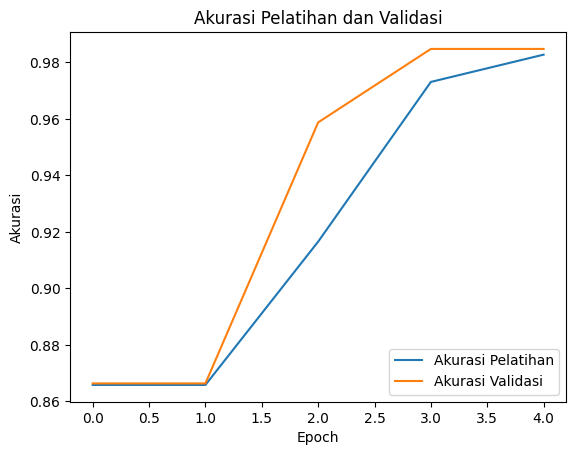

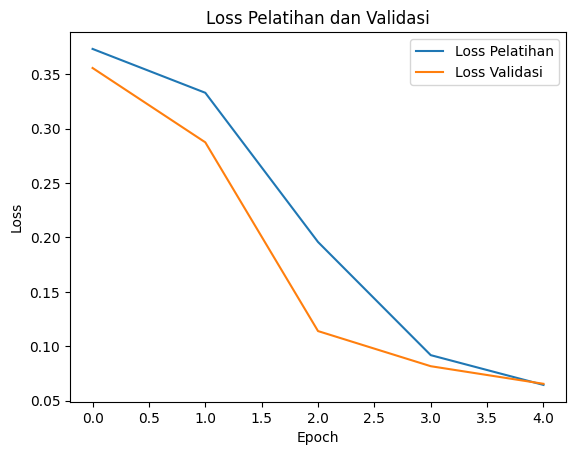

In [11]:
# Visualisasi proses pelatihan
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


## Prediksi Data Baru
Pesan baru diprediksi sebagai spam atau ham. Data diproses terlebih dahulu menggunakan tokenisasi dan padding, kemudian probabilitas dihitung oleh model, dan hasilnya dikonversi menjadi label.

In [12]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Data baru untuk prediksi
new_data = ["Hi, are we still meeting at 3 PM today for the project discussion?"]

# Preprocess data baru: Tokenisasi dan padding
new_data_preprocessed = tokenizer.texts_to_sequences(new_data)
new_data_padded = pad_sequences(new_data_preprocessed, padding='post', maxlen=100)

# Prediksi dengan model
new_predictions = model.predict(new_data_padded)

# Konversi probabilitas menjadi label (0 atau 1)
predicted_labels = (new_predictions > 0.5).astype(int)

# Cetak hasil prediksi bersama labelnya
for text, prediction, label in zip(new_data, new_predictions, predicted_labels):
    label_name = "spam" if label == 1 else "ham"
    print(f"Text: {text}")
    print(f"Prediction (probability): {prediction[0]:.4f}")
    print(f"Predicted label: {label_name}")
    print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Text: Hi, are we still meeting at 3 PM today for the project discussion?
Prediction (probability): 0.0514
Predicted label: ham
--------------------------------------------------


In [13]:
model.count_params()

324225